### aim: 

### date: 

In [42]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [43]:
# ================================
# IMPORTS
# ================================
import os
import glob
import pickle
import time
import warnings
from datetime import datetime
from importlib import reload

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import seawater

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams
import matplotlib.path as mpath

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cmocean import cm

# Jupyter magic
%matplotlib inline

# Suppress warnings
warnings.filterwarnings('ignore')

# ================================
# FONT CONFIGURATION
# ================================
# Disable LaTeX (use mathtext with chosen font)
plt.rcParams['text.usetex'] = False

# Base font size
fs = 11

# Path to Gill Sans
gill_sans_path = "/gpfs/home/mep22dku/scratch/FONTS/gill-sans/GillSansMedium.otf"

# Try to load custom font
if os.path.exists(gill_sans_path):
    font_manager.fontManager.addfont(gill_sans_path)
    gill_font_name = font_manager.FontProperties(fname=gill_sans_path).get_name()
    chosen_font = gill_font_name
    print(f"✓ Using custom font: {gill_font_name}")
else:
    chosen_font = "DejaVu Sans"
    print("⚠️ Gill Sans not found, using fallback: DejaVu Sans")

# Apply font settings
rcParams.update({
    'font.size': fs,
    'font.family': chosen_font,
    'axes.titlesize': fs,
    'axes.labelsize': fs,
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
    'legend.fontsize': fs,
    'mathtext.fontset': 'custom',
    'mathtext.rm': chosen_font,
    'mathtext.it': chosen_font,
    'mathtext.bf': chosen_font,
})

✓ Using custom font: Gill Sans


## dictionary for model specs

In [44]:
# Define datasets with their metadata
ml = {
    'TJ_LA50': {'desc': 'base A run', 'start': 1940, 'end': 2024,
                'no': 0, 'linestyle': '-'},
    'TJ_LC50': {'desc': 'base C run', 'start': 1940, 'end': 2024,
                'no': 0, 'linestyle': ':'},
    'TJ_LAH3': {'desc': 'A run with 0.3Sv hosing', 'start': 1940, 'end': 2024,
                'no': 3, 'linestyle': '-'},
    'TJ_LAH6': {'desc': 'A run with 0.6Sv hosing', 'start': 1940, 'end': 1992,
                'no': 5, 'linestyle': '-'},
}


## colormaps

In [45]:
#kostelec - polsko
kostelec_6 = ['#C94B3C', '#E47A5C', '#A8B89C', '#6B9B7D', '#7FA4B8', '#4A3830']
kostelec_12 = ['#B23D32', '#C94B3C', '#E47A5C', '#D89B7A', '#E5C9A8', '#C8D4B8', '#A8B89C', '#6B9B7D', '#7FA4B8', '#5B7A8C', '#4A3830', '#2A1F1A']

#prachov - jezero 
prachovjezero_6 = ['#E85A2A', '#F4A63D', '#6B8C3E', '#5B9BAD', '#4A6B8A', '#6B3428']
prachovjezero_12 = ['#D84B28', '#E85A2A', '#F27435', '#F4A63D', '#D4B665', '#89A648', '#6B8C3E', '#4E7054', '#5B9BAD', '#4A6B8A', '#6B3428', '#3D2820']

# Tatry 
tatry_6 = ['#9B7850', '#D4C8A8', '#5B7F68', '#7BA6BC', '#A8BECF', '#3A4F3C']
tatry_12 = ['#7A5F40', '#9B7850', '#C4B090', '#E5D8B8', '#B8D090', '#8FAB80', '#5B7F68', '#5B7B7C', '#7BA6BC', '#A8BECF', '#3A4F3C', '#2B3A2E']
#cesky raj
ceskyraj_6 = ['#B8734E', '#D4A562', '#6B8BA8', '#4B6B8C', '#8B5B7A', '#3A2F28']
ceskyraj_12 = ['#A85C3C', '#B8734E', '#D49558', '#D4A562', '#E5C485', '#9CB68A', '#6B8B72', '#6B8BA8', '#4B6B8C', '#8B5B7A', '#5B3F4A', '#3A2F28']

## prachov - skaly
prachovskaly_6 = ['#B8844E', '#D4A865', '#6B8B5C', '#4B7B8C', '#2B5B8C', '#1B3F5C']
prachovskaly_12 = ['#9B6B3C', '#B8844E', '#C89B5A', '#D4A865', '#E5C68A', '#8BA872', '#6B8B5C', '#4B6B5A', '#5B8B9C', '#4B7B8C', '#2B5B8C', '#1B3F5C']

## jested lanovka
jested_6 = ['#D86B45', '#D4B870', '#8FAB7C', '#5B7B8C', '#6B8BAC', '#3A5B48']
jested_12 = ['#C85B3A', '#D86B45', '#E59B58', '#D4B870', '#E5D090', '#B8C88C', '#8FAB7C', '#6B8B78', '#5B7B8C', '#6B8BAC', '#4B6B5C', '#3A5B48']

## krkonose 
krkonose_6 = ['#E5A542', '#C4D858', '#6B8B5C', '#4B6B8C', '#7A9BAC', '#8B6B47']
krkonose_12 = ['#B87A3C', '#E5A542', '#F5C855', '#D4DB6A', '#C4D858', '#A8C850', '#6B8B5C', '#5B7B6C', '#4B6B8C', '#7A9BAC', '#8B6B47', '#5B4B38']

## dumbier
dumbier_6 = ['#D87845', '#E5C8A0', '#4B7BC2', '#6B9BD8', '#7AB8E5', '#1A2B3A']
dumbier_12 = ['#C86838', '#D87845', '#E59B68', '#E5C8A0', '#F5E8D0', '#A8C8E5', '#7AB8E5', '#6B9BD8', '#4B7BC2', '#3A5B8C', '#2A3B5C', '#1A2B3A']

## help functions to check TS

In [46]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/data/greenocean/software/resources/CDFTOOLS/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

def make_amoc_nc(simulationID, yrFrom = 1959, yrTo = 2022):

    tmoc = xr.open_mfdataset(make_yearlist(yrFrom, yrTo, simulationID))
    tdat = get_max_amoc(tmoc)
    nicetime = tmoc.indexes['time_counter'].to_datetimeindex()

    resultsdir = '/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/AMOC-LoP-202510/data/'
    parm = 'AMOC'
    outputFile = f'{resultsdir}{parm}_{simulationID}_{yrFrom}-{yrTo}.nc'
    print(outputFile)
    
    data_vars = {'AMOC':(['TIME'], tdat,
    {'units': 'Sv',
    'long_name':'Atlantic Meridional Overturning Circulation, max of streamfunction at 26N'}),
    }
    # define coordinates
    coords = {'TIME': (['TIME'], nicetime)}
    # define global attributes
    attrs = {'made in':'AMOC-PLANKTOM/makeAMOC_modelts.ipynb',
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
    ds.to_netcdf(outputFile)

## extract amoc timeseries

In [47]:
extract = True
if extract:
    
    for m in ml:

        tnam = f'TOM12_{m}'
        tst = ml[m]['start']
        ten = ml[m]['end']
        print(f'{tnam} {tst} {ten}')
        make_amoc_nc(tnam, yrFrom = tst, yrTo = ten)


TOM12_TJ_LA50 1940 2024
/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/AMOC-LoP-202510/data/AMOC_TOM12_TJ_LA50_1940-2024.nc
TOM12_TJ_LC50 1940 2024
/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/AMOC-LoP-202510/data/AMOC_TOM12_TJ_LC50_1940-2024.nc
TOM12_TJ_LAH3 1940 2024
/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/AMOC-LoP-202510/data/AMOC_TOM12_TJ_LAH3_1940-2024.nc
TOM12_TJ_LAH6 1940 1992
/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM/AMOC-LoP-202510/data/AMOC_TOM12_TJ_LAH6_1940-1992.nc


✓ Loaded TJ_LA50: base A run
✓ Loaded TJ_LC50: base C run
✓ Loaded TJ_LAH3: A run with 0.3Sv hosing
✓ Loaded TJ_LAH6: A run with 0.6Sv hosing


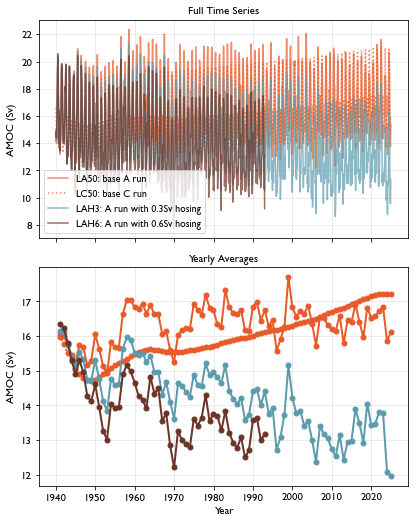

In [55]:
colormap = prachovjezero_6

# ================================
# LOAD AMOC DATASETS
# ================================
base_path = '/gpfs/home/mep22dku/scratch/AMOC-PLANKTOM'

# Load all datasets
amoc_data = {}
for name, info in ml.items():
    path = f"{base_path}/AMOC-LoP-202510/data/AMOC_TOM12_{name}_{info['start']}-{info['end']}.nc"
    try:
        amoc_data[name] = xr.open_dataset(path)
        print(f"✓ Loaded {name}: {info['desc']}")
    except FileNotFoundError:
        print(f"⚠️ Could not find {name}: {path}")

# ================================
# PLOT AMOC TIME SERIES
# ================================
# Define colormap

fact = 0.5
# Create figure with golden ratio (width:height = 1.618:1, roughly 3x5)
fig, axs = plt.subplots(2, 1, figsize=(12 * fact, 12/1.618 * 2 * fact), 
                        facecolor='w', edgecolor='k', sharex=True)

# Plot full time series on top panel
for name, info in ml.items():
    if name in amoc_data:
        ds = amoc_data[name]
        axs[0].plot(ds.TIME, ds.AMOC, 
                    label=f"{name.replace('TJ_', '')}: {info['desc']}", 
                    linestyle=info['linestyle'],
                    color=colormap[info['no']],
                    linewidth=1.5, alpha=0.7)

axs[0].set_ylabel('AMOC (Sv)', fontsize=fs)
axs[0].legend(loc='best', frameon=True, fontsize=fs-1)
axs[0].grid(alpha=0.3)
axs[0].set_title('Full Time Series', fontsize=fs)

# Plot yearly averages on bottom panel
for name, info in ml.items():
    if name in amoc_data:
        ds = amoc_data[name]
        # Resample to yearly averages
        yearly = ds.AMOC.resample(TIME='1Y').mean()
        axs[1].plot(yearly.TIME, yearly, 
                    label=f"{name.replace('TJ_', '')}: {info['desc']}", 
                    linestyle=info['linestyle'],
                    color=colormap[info['no']],
                    linewidth=2, marker='o', markersize=5)

axs[1].set_ylabel('AMOC (Sv)', fontsize=fs)
axs[1].set_xlabel('Year', fontsize=fs)
#axs[1].legend(loc='best', frameon=True, fontsize=fs-1)
axs[1].grid(alpha=0.3)
axs[1].set_title('Yearly Averages', fontsize=fs)

plt.tight_layout()
plt.show()

In [49]:
ds.TIME

<xarray.DataArray 'TIME' (TIME: 636)>
array(['1940-01-16T12:00:00.000000000', '1940-02-15T00:00:00.000000000',
       '1940-03-16T12:00:00.000000000', ..., '1992-10-16T12:00:00.000000000',
       '1992-11-16T00:00:00.000000000', '1992-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * TIME     (TIME) datetime64[ns] 1940-01-16T12:00:00 ... 1992-12-16T12:00:00